In [8]:
import torch
import sys
import pandas as pd
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
# sys.path.append('../')
# from data_utils import ABSADataset


# loading dataset

In [10]:
from torch.utils.data import Dataset

class ABSADataset(Dataset):
    def __init__(self, fname, tokenizer):
        """
        loading dataset
        
        fname: data_path
        
        tokenizer must have function called text_to_sequence
        """
        fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        lines = fin.readlines()
        fin.close()

        all_data = []
        for i in range(0, len(lines), 3):
            #print ('one-single-line : ',lines[i])
            text_left, _, text_right = [s.lower().strip() for s in lines[i].partition("$T$")]
            print ('text_left : ',text_left)
            print ('text_right : ',text_right)
            aspect = lines[i + 1].lower().strip()
            print ('aspect : ',aspect)
            polarity = lines[i + 2].strip()
            print ('polarity : ', polarity)
            text_raw_indices = tokenizer.text_to_sequence(text_left + " " + aspect + " " + text_right)
            #print ('text_raw_indices', tokenizer.tokenizer.convert_ids_to_tokens(text_raw_indices))
            text_raw_without_aspect_indices = tokenizer.text_to_sequence(text_left + " " + text_right)
            #print ('text_raw_without_aspect_indices', tokenizer.tokenizer.convert_ids_to_tokens(text_raw_without_aspect_indices))

            text_left_indices = tokenizer.text_to_sequence(text_left)
            text_left_with_aspect_indices = tokenizer.text_to_sequence(text_left + " " + aspect)
            text_right_indices = tokenizer.text_to_sequence(text_right, reverse=True)
            text_right_with_aspect_indices = tokenizer.text_to_sequence(" " + aspect + " " + text_right, reverse=True)
            aspect_indices = tokenizer.text_to_sequence(aspect)
            left_context_len = np.sum(text_left_indices != 0)
            aspect_len = np.sum(aspect_indices != 0)
            aspect_in_text = torch.tensor([left_context_len.item(), (left_context_len + aspect_len - 1).item()])
            polarity = int(polarity) + 1

            text_bert_indices = tokenizer.text_to_sequence('[CLS] ' + text_left + " " + aspect + " " + text_right + ' [SEP] ' + aspect + " [SEP]")
            bert_segments_ids = np.asarray([0] * (np.sum(text_raw_indices != 0) + 2) + [1] * (aspect_len + 1))
            bert_segments_ids = pad_and_truncate(bert_segments_ids, tokenizer.max_seq_len)

            text_raw_bert_indices = tokenizer.text_to_sequence("[CLS] " + text_left + " " + aspect + " " + text_right + " [SEP]")
            aspect_bert_indices = tokenizer.text_to_sequence("[CLS] " + aspect + " [SEP]")

            data = {
                'text_bert_indices': text_bert_indices,
                'bert_segments_ids': bert_segments_ids,
                'text_raw_bert_indices': text_raw_bert_indices,
                'aspect_bert_indices': aspect_bert_indices,
                'text_raw_indices': text_raw_indices,
                'text_raw_without_aspect_indices': text_raw_without_aspect_indices,
                'text_left_indices': text_left_indices,
                'text_left_with_aspect_indices': text_left_with_aspect_indices,
                'text_right_indices': text_right_indices,
                'text_right_with_aspect_indices': text_right_with_aspect_indices,
                'aspect_indices': aspect_indices,
                'aspect_in_text': aspect_in_text, # aspect_in_text needed aspect shoule be in the text
                'polarity': polarity,
            }

            all_data.append(data)
        self.data = all_data # list of dict
        
    def get_dataframe(self, tokenizer):
        """
        Conver dataset into DataFrame(Pandas)
        """
        df = []
        columns_name = []
        for i in range(len(self.data)):
            tmp = []
            for k, v in self.data[i].items():
                try:
                    to_str = " ".join(tokenizer.tokenizer.convert_ids_to_tokens(v))
                    #print (to_str)
                    tmp.append(to_str)
                except:
                    if k == 'aspect_in_text':
                        # it's a 1-D tensor wtih shape of (2,), representing the start and end index of the aspect
                        v = v.numpy()  # 1-D tensor
                        #print (v.shape)
                    tmp.append(v)
                if i <= 0:
                    columns_name.append(k)
            df.append(tmp)
        df = pd.DataFrame(df,columns=columns_name)   
        return df
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

dataset_files = {
'twitter': {
    'train': './datasets/acl-14-short-data/train.raw',
    'test': './datasets/acl-14-short-data/test.raw'
},
'restaurant': {
    'train': './datasets/semeval14/Restaurants_Train.xml.seg',
    'test': './datasets/semeval14/Restaurants_Test_Gold.xml.seg'
},
'laptop': {
    'train': '../datasets/semeval14/Laptops_Train.xml.seg',
    'test': '../datasets/semeval14/Laptops_Test_Gold.xml.seg'
},
'headphone':{
    "train":"../datasets/headphone/headphone_train.txt",
    "test":"../datasets/headphone/headphone_test.txt"
    
}
}

# tokenizer

from pytorch_pretrained_bert import BertTokenizer
import numpy as np

def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    """
    padding: post means pad with '[PAD]'(BERT) in the last of sentence.
    """
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

class Tokenizer4Bert:
    def __init__(self, max_seq_len, pretrained_bert_name = "bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_bert_name)
        self.max_seq_len = max_seq_len

    def text_to_sequence(self, text, reverse=False, padding='post', truncating='post'):
        ls_tokens = self.tokenizer.tokenize(text)
        sequence = self.tokenizer.convert_tokens_to_ids(ls_tokens)
        if len(sequence) == 0:
            sequence = [0]
        if reverse:
            sequence = sequence[::-1]
        return pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)

# path
train_path = dataset_files['laptop']['train']
test_path = dataset_files['laptop']['test']

# paras 
max_seq_len = 80
pretrained_bert_name = "bert-base-uncased"
tokenizer = Tokenizer4Bert(max_seq_len, pretrained_bert_name)

trainset = ABSADataset(train_path, tokenizer)
testset = ABSADataset(test_path, tokenizer)
print ('number of traning data', len(trainset))
print ('number of testing data', len(testset))


text_left :  i charge it at night and skip taking the
text_right :  with me because of the good battery life .
aspect :  cord
polarity :  0
text_left :  i charge it at night and skip taking the cord with me because of the good
text_right :  .
aspect :  battery life
polarity :  1
text_left :  the tech guy then said the
text_right :  does not do 1-to-1 exchange and i have to direct my concern to the `` sales '' team , which is the retail shop which i bought my netbook from .
aspect :  service center
polarity :  -1
text_left :  the tech guy then said the service center does not do 1-to-1 exchange and i have to direct my concern to the
text_right :  , which is the retail shop which i bought my netbook from .
aspect :  "sales" team
polarity :  -1
text_left :  the
text_right :  then said the service center does not do 1-to-1 exchange and i have to direct my concern to the `` sales '' team , which is the retail shop which i bought my netbook from .
aspect :  tech guy
polarity :  0
text_left :

text_right :  is out of country .
aspect :  warranty service
polarity :  -1
text_left :  but now i have realized its a problem with this
text_right :  .
aspect :  brand
polarity :  -1
text_left :  i sent it back to toshiba twice they covered it under the
text_right :  .
aspect :  warranty
polarity :  1
text_left :  i was looking for a mac which is portable and has all the
text_right :  that i was looking for .
aspect :  features
polarity :  1
text_left :  also kinda loud when the
text_right :  was running .
aspect :  fan
polarity :  -1
text_left :  in desparation , i called their
text_right :  and was told that my warranty had expired -lrb- 2 days old -rrb- and that the priviledge of talking to a technician would cost me -lrb- `` have your credit card ready '' -rrb- .
aspect :  customer service number
polarity :  0
text_left :  in desparation , i called their customer service number and was told that my
text_right :  had expired -lrb- 2 days old -rrb- and that the priviledge of talking

text_left :  it had a cooling system malfunction after 10 minutes of general
text_right :  , and would not move past this error .
aspect :  use
polarity :  0
text_left :  i can render avchd movies with little effort , which was a problem for most pc 's unless you had a
text_right :  .
aspect :  quad core i7
polarity :  1
text_left :  after talking it over with the very knowledgeable
text_right :  , i chose the macbook pro over the white macbook .
aspect :  sales associate
polarity :  1
text_left :  if you really want a bang-up
text_right :  and do n't need to run windows applications , go with an apple ;
aspect :  system
polarity :  1
text_left :  if you really want a bang-up system and do n't need to run
text_right :  , go with an apple ;
aspect :  windows applications
polarity :  0
text_left :  you wo n't have to spend gobs of money on some inefficient
text_right :  that needs to be updated every month and that constantly drains your wallet .
aspect :  virus program
polarity :  -1
te

text_right :  would be there , but the software would hang after installation was 1/2 way done .
aspect :  fingerprint reader driver
polarity :  -1
text_left :  the bluetooth was not there at all , and the fingerprint reader driver would be there , but the
text_right :  would hang after installation was 1/2 way done .
aspect :  software
polarity :  -1
text_left :  great
text_right :  , speed , display .
aspect :  battery
polarity :  1
text_left :  great battery ,
text_right :  , display .
aspect :  speed
polarity :  1
text_left :  great battery , speed ,
text_right :  .
aspect :  display
polarity :  1
text_left :  the
text_right :  was fast , and i would not hesitate to purchase this laptop again .
aspect :  delivery
polarity :  1
text_left :  i 've been impressed with the
text_right :  and the performance for such a small amount of memory .
aspect :  battery life
polarity :  1
text_left :  i 've been impressed with the battery life and the
text_right :  for such a small amount of memo

text_left :  the
text_right :  i purchased this from sent it back , , , , , eventually i got a new or repaired machine approximately 3 weeks later .
aspect :  tech store
polarity :  -1
text_left :  really like the textured
text_right :  which shows no fingerprints .
aspect :  surface
polarity :  1
text_left :  the
text_right :  is bright and the keyboard is nice ;
aspect :  screen
polarity :  1
text_left :  the screen is bright and the
text_right :  is nice ;
aspect :  keyboard
polarity :  1
text_left :  but the machine is awesome and
text_right :  is great and i love snow leopard x.
aspect :  ilife
polarity :  1
text_left :  but the machine is awesome and ilife is great and i love
text_right :  .
aspect :  snow leopard x
polarity :  1
text_left :  high
text_right :  , however .
aspect :  price tag
polarity :  -1
text_left :  i thought learning the
text_right :  would be hard , but it is easily picked up if you are familiar with a pc .
aspect :  mac os
polarity :  1
text_left :  i had 

polarity :  -1
text_left :  the
text_right :  is a bit cheaply made so it will be interesting to see how long it holds up .
aspect :  body
polarity :  -1
text_left :  the
text_right :  blows my desktop out of the water when it comes to rendering videos .
aspect :  i5
polarity :  -1
text_left :  with a mac you do n't have to worry about
text_right :  or firewall , it 's so wonderful .
aspect :  antivirus software
polarity :  0
text_left :  with a mac you do n't have to worry about antivirus software or
text_right :  , it 's so wonderful .
aspect :  firewall
polarity :  0
text_left :  am very glad i bought it , great netbook , low
text_right :  .
aspect :  price
polarity :  1
text_left :  the
text_right :  also assists you very nicely when choosing which computer is right for you : -rrb-
aspect :  apple team
polarity :  1
text_left :  i think part of the problem with this computer is
text_right :  , yet i know vista is n't the entire issue because my latest purchase was my acer and it al

aspect :  techs at hp
polarity :  -1
text_left :  this is my second one and the same problem , bad
text_right :  unreliable overall , this will be my second time returning this laptop back to best buy .
aspect :  video card
polarity :  -1
text_left :  with awesome
text_right :  and assuring security , it 's perfect !
aspect :  graphics
polarity :  1
text_left :  with awesome graphics and assuring
text_right :  , it 's perfect !
aspect :  security
polarity :  1
text_left :  laptop was in new condition and operational , but for the
text_right :  problem when 1st sent for repair .
aspect :  audio
polarity :  -1
text_left :  i was disappointed when i realized that the
text_right :  does n't light up on this model .
aspect :  keyboard
polarity :  -1
text_left :  it
text_right :  perfectly .
aspect :  runs
polarity :  1
text_left :  the laptop was very easy to
text_right :  .
aspect :  set up
polarity :  1
text_left :  sometimes the
text_right :  even goes black on this computer .
aspect :  

text_right :  and it simply makes sense .
aspect :  use
polarity :  1
text_left :  however , i may have inadvertently thrown out one of the
text_right :  with the shipping carton .
aspect :  batteries
polarity :  0
text_left :  however , i may have inadvertently thrown out one of the batteries with the
text_right :  .
aspect :  shipping carton
polarity :  0
text_left :  it is so much easier to
text_right :  
aspect :  use
polarity :  1
text_left :  there is no need to open a
text_right :  first and the cliick open or import .
aspect :  program
polarity :  1
text_left :  it is so nice not to worry about that and the extra expense that comes along with the necessary
text_right :  on pc 's .
aspect :  virus protection
polarity :  1
text_left :  three weeks after i bought the netbook , the
text_right :  quit working .
aspect :  screen
polarity :  -1
text_left :  the
text_right :  screams , and because of the unique way that apple osx 16 functions , most of the graphics are routed through t

text_left :  have had many higher
text_right :  computers crash and burn long before ever got to use all that great memory and speed , etc. .
aspect :  priced
polarity :  -1
text_left :  i would recommend it just because of the
text_right :  probably because thats the only thing i really care about .
aspect :  internet speed
polarity :  1
text_left :  there are several
text_right :  for school or office use -lrb- pages , numbers , keynote , etc. -rrb- , music -lrb- garageband -rrb- , photo management -lrb- photo booth , iphoto -rrb- , video-editing or movie-making -lrb- imovie -rrb- , etc. .
aspect :  programs
polarity :  0
text_left :  there are several programs for school or office use -lrb- pages , numbers , keynote , etc. -rrb- , music -lrb-
text_right :  -rrb- , photo management -lrb- photo booth , iphoto -rrb- , video-editing or movie-making -lrb- imovie -rrb- , etc. .
aspect :  garageband
polarity :  0
text_left :  there are several programs for school or office use -lrb- pages 

text_right :  than my hunk of crap vaio .
aspect :  quality
polarity :  1
text_left :  -lrb- beware , their
text_right :  could send you back making you feel that only they know what a computer is .
aspect :  staff
polarity :  -1
text_left :  
text_right :  being the main issue .
aspect :  games
polarity :  -1
text_left :  my sister has the same mac as me and she is in a band and uses
text_right :  to record and edit .
aspect :  garageband
polarity :  0
text_left :  they say that this will invalidate the
text_right :  on the hard drive -lrb- i do n't really understand why but anyway -rrb- .
aspect :  warranty
polarity :  -1
text_left :  they say that this will invalidate the warranty on the
text_right :  -lrb- i do n't really understand why but anyway -rrb- .
aspect :  hard drive
polarity :  0
text_left :  and looks very sexyy :d really the mac book pro is the best laptop specially for students in college if you are not caring about
text_right :  .
aspect :  price
polarity :  -1
text_l

text_left :  screen is awesome ,
text_right :  is good .
aspect :  battery life
polarity :  1
text_left :  the black model also has a very nice seamless
text_right :  - one of the better looking notebooks i 've seen .
aspect :  appearance
polarity :  1
text_left :  the
text_right :  is so 3rd world it might as well not even bother .
aspect :  technical service for dell
polarity :  -1
text_left :  the
text_right :  were awful and the warranty is n't even worth the cheap payment on the computer .
aspect :  graphics
polarity :  -1
text_left :  the graphics were awful and the
text_right :  is n't even worth the cheap payment on the computer .
aspect :  warranty
polarity :  -1
text_left :  they gave me a hard time yet again , but their was a malfunction in the
text_right :  itself , it did n't die .
aspect :  battery
polarity :  -1
text_left :  if you do n't feel comfortable doing it yourself , just buy the
text_right :  and be happy , plus it looks nice , i bought the white one from best b

text_left :  great os , fabulous improvements to the existing line bumping up the processor speed and adding the
text_right :  .
aspect :  thunderbolt port
polarity :  1
text_left :  the
text_right :  stopped working on mine after 10 months .
aspect :  lcd screen
polarity :  -1
text_left :  
text_right :  are crisp and clean .
aspect :  images
polarity :  1
text_left :  although its
text_right :  compared to windows xp sucks .
aspect :  windows vista
polarity :  -1
text_left :  although its windows vista compared to
text_right :  sucks .
aspect :  windows xp
polarity :  1
text_left :  we have had numerous problems with
text_right :  , such as adobe flash player just quits and has to be uninstalled and then reinsalled , internet explore just quits and you lose whatever you were working on , also , the same windows update has appeared on this computer since we got it and has been updated probably 400 times , the same update .
aspect :  vista
polarity :  -1
text_left :  we have had numero

text_left :  i run dreamweaver ,
text_right :  , photoshop , safari , firefox , msn messenger and a few other applications constantly at the same time .
aspect :  final cut pro 7
polarity :  0
text_left :  i run dreamweaver , final cut pro 7 ,
text_right :  , safari , firefox , msn messenger and a few other applications constantly at the same time .
aspect :  photoshop
polarity :  0
text_left :  i run dreamweaver , final cut pro 7 , photoshop ,
text_right :  , firefox , msn messenger and a few other applications constantly at the same time .
aspect :  safari
polarity :  0
text_left :  i run dreamweaver , final cut pro 7 , photoshop , safari ,
text_right :  , msn messenger and a few other applications constantly at the same time .
aspect :  firefox
polarity :  0
text_left :  i run dreamweaver , final cut pro 7 , photoshop , safari , firefox ,
text_right :  and a few other applications constantly at the same time .
aspect :  msn messenger
polarity :  0
text_left :  i was told by many tha

text_left :  the
text_right :  take a little getting used to , but have loved the macbook pro .
aspect :  key bindings
polarity :  -1
text_left :  
text_right :  is reasonable size .
aspect :  keyboard
polarity :  1
text_left :  keyboard is reasonable
text_right :  .
aspect :  size
polarity :  1
text_left :  i find myself using the
text_right :  more than i thought i would .
aspect :  10-key
polarity :  1
text_left :  
text_right :  noise : the fan made a constant hissing noise in the background .
aspect :  fan
polarity :  -1
text_left :  fan noise : the
text_right :  made a constant hissing noise in the background .
aspect :  fan
polarity :  -1
text_left :  the
text_right :  is bright and clear , the operating system is solid and friendly to a novice .
aspect :  screen
polarity :  1
text_left :  the screen is bright and clear , the
text_right :  is solid and friendly to a novice .
aspect :  operating system
polarity :  1
text_left :  it has a .1 ghz faster
text_right :  and a stock 50

text_left :  even though it is running snow leopard , 2.4 ghz c2d is a bit of an antiquated cpu and thus the occasional
text_right :  would appear when running office mac applications such as word or excel .
aspect :  spinning wheel
polarity :  -1
text_left :  there is no number
text_right :  to the right of the keyboard which is a bummer .
aspect :  pad
polarity :  -1
text_left :  there is no number pad to the right of the
text_right :  which is a bummer .
aspect :  keyboard
polarity :  -1
text_left :  after 20-30 min the
text_right :  of the notebook switched off .
aspect :  screen
polarity :  -1
text_left :  if upgrade is possible to the full
text_right :  , then i will truly be a very happy geek .
aspect :  windows 7
polarity :  1
text_left :  i was originally concerned that i could n't view work i had done in college on my mac because of the pc formatting , but i was even more thrilled to learn of
text_right :  like ilife and iwork that allow you to convert your pc documents into 

text_left :  tons of bloatware and junk
text_right :  .
aspect :  programs
polarity :  -1
text_left :  lots of extra
text_right :  but the keyboard is ridiculously small .
aspect :  space
polarity :  1
text_left :  lots of extra space but the
text_right :  is ridiculously small .
aspect :  keyboard
polarity :  -1
text_left :  it 's so bad that i 'm thinking i only got half a
text_right :  or something .
aspect :  battery
polarity :  -1
text_left :  good
text_right :  , long battery life , largest hard drive and windows 7 .
aspect :  keyboard
polarity :  1
text_left :  good keyboard , long
text_right :  , largest hard drive and windows 7 .
aspect :  battery life
polarity :  1
text_left :  good keyboard , long battery life , largest
text_right :  and windows 7 .
aspect :  hard drive
polarity :  1
text_left :  good keyboard , long battery life , largest hard drive and
text_right :  .
aspect :  windows 7
polarity :  1
text_left :  the
text_right :  is very quick and effective as i load web

aspect :  ddr5
polarity :  1
text_left :  it could be a perfect laptop if it would have faster system memory and its radeon 5850 would have ddr5 instead of
text_right :  .
aspect :  ddr3
polarity :  -1
text_left :  not only are the versions of these
text_right :  able to be saved , worked on and opened on both a pc and mac , the versions of these programs on a mac are graphically and functionally superior .
aspect :  programs
polarity :  1
text_left :  not only are the versions of these programs able to be saved , worked on and opened on both a pc and mac , the versions of these
text_right :  on a mac are graphically and functionally superior .
aspect :  programs
polarity :  1
text_left :  the
text_right :  gives you the power to work on these projects seamlessly , and multiple at a time if you sowish .
aspect :  speed
polarity :  1
text_left :  awesome laptop and the perfect
text_right :  to carry around in college .
aspect :  size
polarity :  1
text_left :  a month later , we reinsta

polarity :  -1
text_left :  called tech support and got the usual acer `` we do n't support software but for $ $ $ we can help you '' i explained there was no software involved in
text_right :  .
aspect :  booting
polarity :  -1
text_left :  the
text_right :  are great , like iphoto -lrb- love the editing capabilities -rrb- , imail -lrb- which can incorporate with the address book on the ipod and ipad -rrb- , imovie , etc. .
aspect :  programs
polarity :  1
text_left :  the programs are great , like
text_right :  -lrb- love the editing capabilities -rrb- , imail -lrb- which can incorporate with the address book on the ipod and ipad -rrb- , imovie , etc. .
aspect :  iphoto
polarity :  1
text_left :  the programs are great , like iphoto -lrb- love the editing capabilities -rrb- ,
text_right :  -lrb- which can incorporate with the address book on the ipod and ipad -rrb- , imovie , etc. .
aspect :  imail
polarity :  1
text_left :  the programs are great , like iphoto -lrb- love the editing

text_left :  it 's graphics are n't bad at all , for the lower end of the macbook pro spectrum , easily capable of running starcraft ii and other games with comparable
text_right :  .
aspect :  graphics
polarity :  0
text_left :  i have
text_right :  , so i am unable to install and uninstall some programs .
aspect :  vista
polarity :  -1
text_left :  i have vista , so i am unable to install and uninstall some
text_right :  .
aspect :  programs
polarity :  -1
text_left :  i have vista , so i am unable to
text_right :  and uninstall some programs .
aspect :  install
polarity :  -1
text_left :  i have vista , so i am unable to install and
text_right :  some programs .
aspect :  uninstall
polarity :  -1
text_left :  the
text_right :  is bright and vivid and the keyboard is very easy to use , very important for use quick typers .
aspect :  screen
polarity :  1
text_left :  the screen is bright and vivid and the
text_right :  is very easy to use , very important for use quick typers .
aspect

text_left :  this is what i call a good
text_right :  
aspect :  after sales service.
polarity :  1
text_left :  i took off a star because the machine has a lot of junk
text_right :  on it .
aspect :  software
polarity :  -1
text_left :  with what i do know how to do , the computer
text_right :  beautiful .
aspect :  works
polarity :  1
text_left :  tried to make a
text_right :  wouldnt get passed the first recovery disk .
aspect :  recovey disk
polarity :  -1
text_left :  tried to make a recovey disk wouldnt get passed the first
text_right :  .
aspect :  recovery disk
polarity :  -1
text_left :  most everything is fine with this machine :
text_right :  , capacity , build .
aspect :  speed
polarity :  1
text_left :  most everything is fine with this machine : speed ,
text_right :  , build .
aspect :  capacity
polarity :  1
text_left :  most everything is fine with this machine : speed , capacity ,
text_right :  .
aspect :  build
polarity :  1
text_left :  for the same
text_right :  , y

polarity :  0
text_left :  when i called to have another one shipped or to get my money back they said the
text_right :  is 23 twenty three days from the date of purchase .
aspect :  return policy
polarity :  -1
text_left :  i sent it back and found this time that the
text_right :  was faulty , so i got a new one and some other fixes they found .
aspect :  battery
polarity :  -1
text_left :  great pick for
text_right :  and affordability .
aspect :  portability
polarity :  1
text_left :  great pick for portability and
text_right :  .
aspect :  affordability
polarity :  1
text_left :  it 's fast , it 's easy easy easy to
text_right :  , easy to hook to my wireless network .
aspect :  set up
polarity :  1
text_left :  it 's fast , it 's easy easy easy to set up , easy to
text_right :  .
aspect :  hook to my wireless network
polarity :  1
text_left :  i previously purchased a 13 '' macbook -lrb- had pro specs and was
text_right :  -rrb- which had a nvidia 9800 -lrb- if i am not mistaken -

text_left :  stopped booting up less than a week after my
text_right :  was up .
aspect :  one-year warranty
polarity :  0
text_left :  but , for the
text_right :  this is a winner .
aspect :  cost
polarity :  1
text_left :  later it held zero
text_right :  and its replacement worked for less than three months .
aspect :  charge
polarity :  -1
text_left :  also , the
text_right :  does not last very long at all .
aspect :  battery
polarity :  -1
text_left :  i bought it from hsn because it was `` bundled '' with extra software , but as it turns out , that
text_right :  just crashes it more often ...
aspect :  software
polarity :  -1
text_left :  i looked around and based off my
text_right :  / features comparison from a brand i trusted i landed here .
aspect :  price
polarity :  0
text_left :  i looked around and based off my price /
text_right :  comparison from a brand i trusted i landed here .
aspect :  features
polarity :  0
text_left :  i constantly had to send my laptop in for
te

text_right :  .
aspect :  features
polarity :  1
text_left :  the only downfall is the
text_right :  only last 1.5-2 .0 hrs when not plugged in .
aspect :  battery
polarity :  -1
text_left :  the
text_right :  on this computer are also stellar - very clear and vivid .
aspect :  graphics
polarity :  1
text_left :  aside from the
text_right :  and the short battery life , lack of a webcam , its great .
aspect :  trial software
polarity :  -1
text_left :  aside from the trial software and the short
text_right :  , lack of a webcam , its great .
aspect :  battery life
polarity :  -1
text_left :  aside from the trial software and the short battery life , lack of a
text_right :  , its great .
aspect :  webcam
polarity :  -1
text_left :  as a die-hard
text_right :  enthusiast , i shunned the idea of a mac until this point .
aspect :  windows
polarity :  1
text_left :  i think that if it is the
text_right :  again so soon that they should replace it .
aspect :  motherboard
polarity :  -1
text_

text_left :  
text_right :  is not upgradable to a longer life battery .
aspect :  battery
polarity :  -1
text_left :  battery is not upgradable to a longer life
text_right :  .
aspect :  battery
polarity :  -1
text_left :  apple has a reputation and is well known for its easy
text_right :  .
aspect :  usage
polarity :  1
text_left :  returned laptop for a 3rd repair and it came back with previous problems fixed -lrb- except for
text_right :  -rrb- but the unit started locking up during use and eventually would not operate at all .
aspect :  speaker grill
polarity :  -1
text_left :  i just plug this into my 22 '' monitor and the speedy
text_right :  performs just as well on this dual-core that my dell did with windows 7 with a quad-core .
aspect :  macosx
polarity :  1
text_left :  i just plug this into my 22 '' monitor and the speedy macosx performs just as well on this dual-core that my dell did with
text_right :  with a quad-core .
aspect :  windows 7
polarity :  1
text_left :  i ju

text_left :  windows vista makes this computer almost unusable for
text_right :  .
aspect :  online service
polarity :  -1
text_left :  i contacted acer and they are giving me free
text_right :  , so do n't go and pay for them , just ask for them and they should give them to you .
aspect :  recovery dvds
polarity :  1
text_left :  now when i order i did not go full scale for the
text_right :  or full keyboard i wanted something for basics of being easy to carry when i use crutchs or wheelchair and with a backpack laptop bag .
aspect :  webcam
polarity :  0
text_left :  now when i order i did not go full scale for the webcam or full
text_right :  i wanted something for basics of being easy to carry when i use crutchs or wheelchair and with a backpack laptop bag .
aspect :  keyboard
polarity :  0
text_left :  now when i order i did not go full scale for the webcam or full keyboard i wanted something for basics of being easy to
text_right :  when i use crutchs or wheelchair and with a bac

text_left :  i had a
text_right :  but , i ca n't use it because it is not compatible .
aspect :  usb connect
polarity :  -1
text_left :  accordingly , i have decided to never purchase another hp product -lrb- my five year old compaq -rrb- lasted 5-years before the
text_right :  crashed .
aspect :  hard drive
polarity :  -1
text_left :  i know that everyone thinks macs are overpriced and overrated , but once you get past the initial
text_right :  you 'll find that they 're worth every penny -lrb- besides , there 's always the financing plan that best buy offers -rrb- .
aspect :  expense
polarity :  -1
text_left :  i love the
text_right :  .
aspect :  multi-touch trackpad
polarity :  1
text_left :  hp is more interested in selling
text_right :  -lrb- which cost more than the netbook new -rrb- then they are in helping or fixing .
aspect :  extended warranties
polarity :  -1
text_left :  hp is more interested in selling extended warranties -lrb- which
text_right :  more than the netbook n

text_left :  needs power and
text_right :  to plug in back instead of side , in the way of operating a mouse in small area .
aspect :  mouse cable
polarity :  -1
text_left :  needs power and mouse cable to plug in back instead of side , in the way of operating a
text_right :  in small area .
aspect :  mouse
polarity :  -1
text_left :  -4
text_right :  , 2 hdd bays * , 16gb ram support - no wireless issues , at least for me .
aspect :  ram slots
polarity :  0
text_left :  -4 ram slots , 2
text_right :  * , 16gb ram support - no wireless issues , at least for me .
aspect :  hdd bays
polarity :  0
text_left :  -4 ram slots , 2 hdd bays * ,
text_right :  - no wireless issues , at least for me .
aspect :  16gb ram support
polarity :  0
text_left :  -4 ram slots , 2 hdd bays * , 16gb ram support - no
text_right :  issues , at least for me .
aspect :  wireless
polarity :  1
text_left :  i agree with the previous comment that
text_right :  is horrible which is a con in my opinion .
aspect :  a

text_left :  they are about the same size
text_right :  .
aspect :  keys
polarity :  0
text_left :  the people are frustrating to work with , the product itself is very cheaply made , and the
text_right :  are less than satisfactory .
aspect :  accessories
polarity :  -1
text_left :  they offer the best
text_right :  in the business , and do n't 3rd party it out like toshiba .
aspect :  warranty
polarity :  1
text_left :  the only problems are the
text_right :  isnt very loud i have to wear headphones .
aspect :  sound
polarity :  -1
text_left :  again -
text_right :  based machines were not giving me anything to work with !
aspect :  windows
polarity :  -1
text_left :  everything about a mac is wonderful , it takes a little used to learning and getting used to the new
text_right :  , but you will learn fast and its all worth it .
aspect :  system
polarity :  0
text_left :  i love the
text_right :  of the computer since i play games on it .
aspect :  size
polarity :  1
text_left :  i l

text_left :  
text_right :  is lasting about 6 hours as i am surfing the web on sundays while checking football scores and watching funny youtube videos .
aspect :  battery
polarity :  0
text_left :  battery is lasting about 6 hours as i am
text_right :  on sundays while checking football scores and watching funny youtube videos .
aspect :  surfing the web
polarity :  0
text_left :  
text_right :  is great for adding pictures right to facebook and other social networking sites .
aspect :  iphoto
polarity :  1
text_left :  in early may i got it back and this time i only had it back for 1 day before it had a new issue so it was sent back in for the 6th time they `` expedited '' the repairs so i was only supposed to have to be without it for 3 days and it was supposed to be fixed , by a ``
text_right :  '' .
aspect :  senior tech
polarity :  -1
text_left :  some features arent friendly -lrb-
text_right :  , sound quality , etc. .
aspect :  volume wheel
polarity :  -1
text_left :  some fea

text_left :  also you may need to
text_right :  it once a day , if for medium use every thing fast and easy with mac the size and look is the most feature that attracted me to it .
aspect :  charge
polarity :  0
text_left :  -lrb- the
text_right :  also uses a firewire connection -rrb- .
aspect :  ibook backup
polarity :  0
text_left :  -lrb- the ibook backup also uses a
text_right :  n -rrb- .
aspect :  firewire connectio
polarity :  0
text_left :  i did think it had a
text_right :  because that was one of my requirements , but forgot to check in the specifications on this one before i purchased .
aspect :  camera
polarity :  0
text_left :  i did think it had a camera because that was one of my requirements , but forgot to check in the
text_right :  on this one before i purchased .
aspect :  specifications
polarity :  0
text_left :  also the
text_right :  is exceptional !
aspect :  display
polarity :  1
text_left :  the computer was shipped to their
text_right :  on june 24 and return

text_right :  and at a reasonable price
aspect :  screen
polarity :  1
text_left :  disappointing for such a lovely screen and at a reasonable
text_right :  
aspect :  price
polarity :  1
text_left :  the only bad thing about it is they give you the worst
text_right :  possible .
aspect :  batteries
polarity :  -1
text_left :  good
text_right :  .
aspect :  price
polarity :  1
text_left :  the
text_right :  is dead !
aspect :  motherboard
polarity :  -1
text_left :  the
text_right :  is fine .
aspect :  speed
polarity :  1
text_left :  hmmm - that high failure rate sure is n't reflected in the
text_right :  .
aspect :  retail price
polarity :  -1
text_left :  it was not clear that the
text_right :  that was loaded on the computer , was a six month trial .
aspect :  microsoft student edition
polarity :  -1
text_left :  good for every day computing and
text_right :  .
aspect :  web browsing
polarity :  1
text_left :  good for
text_right :  and web browsing .
aspect :  every day computing

text_right :  .
aspect :  external drive
polarity :  -1
text_left :  get this computer for
text_right :  and fast processing !!!
aspect :  portability
polarity :  1
text_left :  get this computer for portability and fast
text_right :  !!!
aspect :  processing
polarity :  1
text_left :  i use a
text_right :  but it does n't help .
aspect :  cooling pad
polarity :  -1
text_left :  
text_right :  : the software that comes with this machine is greatly welcomed compared to what windows comes with .
aspect :  supplied software
polarity :  0
text_left :  supplied software : the
text_right :  that comes with this machine is greatly welcomed compared to what windows comes with .
aspect :  software
polarity :  1
text_left :  supplied software : the software that comes with this machine is greatly welcomed compared to what
text_right :  comes with .
aspect :  windows
polarity :  -1
text_left :  i 'm tired of the inept
text_right :  .
aspect :  service
polarity :  -1
text_left :  
text_right :  is

text_right :  and keynotes makes it much easier to create professional looking documents and presentations .
aspect :  pages
polarity :  1
text_left :  in addition , all the design tools on pages and
text_right :  makes it much easier to create professional looking documents and presentations .
aspect :  keynotes
polarity :  1
text_left :  i actually had the
text_right :  replaced twice , the mother board once , the dvd drive twice , then they finally agreed to replace it , -lrb- all of this in less than 1 1/2 years !
aspect :  hard drive
polarity :  -1
text_left :  i actually had the hard drive replaced twice , the
text_right :  once , the dvd drive twice , then they finally agreed to replace it , -lrb- all of this in less than 1 1/2 years !
aspect :  mother board
polarity :  -1
text_left :  i actually had the hard drive replaced twice , the mother board once , the
text_right :  twice , then they finally agreed to replace it , -lrb- all of this in less than 1 1/2 years !
aspect :  dvd

text_left :  after purchasing this thing , i find out that i need a special
text_right :  to connect my camera , and that it can not be purchased at the store - only on line .
aspect :  interface device
polarity :  -1
text_left :  another
text_right :  that is laughable is the chess game .
aspect :  included program
polarity :  -1
text_left :  yes , i thought the
text_right :  was a little much , but i now realize you get what you pay for .
aspect :  expese
polarity :  -1
text_left :  it works great for general internet use ,
text_right :  , home bookkeeping , etc. .
aspect :  microsoft office apps
polarity :  1
text_left :  it works great for general
text_right :  , microsoft office apps , home bookkeeping , etc. .
aspect :  internet use
polarity :  1
text_left :  the
text_right :  was very good , and the product is top quality .
aspect :  price
polarity :  1
text_left :  the price was very good , and the product is top
text_right :  .
aspect :  quality
polarity :  1
text_left :  it p

text_right :  , and monitor to take it with me when i take photos and video .
aspect :  mouse
polarity :  0
text_left :  but sitting on a lap or on a desk in front of you it looks more than big enough -lrb- this could be because im used to my lenovo 10 tablet now -rrb- plus this is a great size if i want to unplug the external keyboard , mouse , and
text_right :  to take it with me when i take photos and video .
aspect :  monitor
polarity :  0
text_left :  the only objection i have is that after you buy it the
text_right :  is a starter and charges for the upgrade .
aspect :  windows 7 system
polarity :  -1
text_left :  i dislike the
text_right :  and size , cubersome .
aspect :  weight
polarity :  -1
text_left :  i dislike the weight and
text_right :  , cubersome .
aspect :  size
polarity :  -1
text_left :  the
text_right :  that turns the volume up and down does n't work in real time .
aspect :  wheel
polarity :  -1
text_left :  i can not be happier with the
text_right :  or product 

text_left :  the battery never held a
text_right :  longer than one hour and within two months , stopped holding a charge for more than ten minutes .
aspect :  charge
polarity :  -1
text_left :  the battery never held a charge longer than one hour and within two months , stopped holding a
text_right :  for more than ten minutes .
aspect :  charge
polarity :  -1
text_left :  after the
text_right :  expired the hard drive went bad and it would have cost more to fix then to replace .
aspect :  warrenty
polarity :  0
text_left :  after the warrenty expired the
text_right :  went bad and it would have cost more to fix then to replace .
aspect :  hard drive
polarity :  -1
text_left :  the
text_right :  is , in my opinion , a great way to think about using your netbook : basics , basics , basics .
aspect :  windows 7 starter
polarity :  1
text_left :  the neat and organized
text_right :  is a welcome change from cluttered and confusing desktop icons .
aspect :  icon list
polarity :  1
text_le

text_right :  would only last me on average about 2.5 to 3 hours .
aspect :  battery
polarity :  -1
text_left :  right
text_right :  and weight for portability .
aspect :  size
polarity :  1
text_left :  right size and
text_right :  for portability .
aspect :  weight
polarity :  1
text_left :  right size and weight for
text_right :  .
aspect :  portability
polarity :  1
text_left :  the
text_right :  also does n't keep up with the claim but still i think macbook is much ahead from the rest of the pack .
aspect :  battery life
polarity :  -1
text_left :  it was loaded with
text_right :  -- delivered with only 1gb of ram , and it was a * dog * .
aspect :  windows vista home premium
polarity :  0
text_left :  it was loaded with windows vista home premium -- delivered with only
text_right :  , and it was a * dog * .
aspect :  1gb of ram
polarity :  -1
text_left :  the reflectiveness of the
text_right :  is only a minor inconvenience if you work in a controlled-lighting environment like me 

text_left :  it has just enough
text_right :  to run smoothly and enough memory to satisfy my needs .
aspect :  ram
polarity :  1
text_left :  it has just enough ram to run smoothly and enough
text_right :  to satisfy my needs .
aspect :  memory
polarity :  1
text_left :  i acually believe the issue is with the
text_right :  , but still requires a return .
aspect :  nvidia grafics card
polarity :  -1
text_left :  my husband got me this for chrismas after getting me a very expensve laptop that did not
text_right :  after 2 days .
aspect :  work
polarity :  -1
text_left :  the
text_right :  is even higher then any other laptop on the market .
aspect :  resolution
polarity :  1
text_left :  then just the other day , my
text_right :  snapped !
aspect :  left "mouse" button
polarity :  -1
text_left :  it is very easy to type on and feels great - besides the added feature that the
text_right :  is lighted .
aspect :  keyboard
polarity :  1
text_left :  it is very easy to type on and feels gr

text_left :  all of the programs -lrb-
text_right :  , pages , numbers -rrb- have an option to save your documents as microsoft compatible , which really eliminates the need for the actual .
aspect :  keynote
polarity :  0
text_left :  all of the programs -lrb- keynote ,
text_right :  , numbers -rrb- have an option to save your documents as microsoft compatible , which really eliminates the need for the actual .
aspect :  pages
polarity :  0
text_left :  all of the programs -lrb- keynote , pages ,
text_right :  -rrb- have an option to save your documents as microsoft compatible , which really eliminates the need for the actual .
aspect :  numbers
polarity :  0
text_left :  sure , the initial out of pocket
text_right :  is greater , but that should not dissuade anyone from the fact that these machines run like none other on the planet , and when i factor in all the money in that i wasted on geek squad and the latest patches to de-corrupt my infested pcs , it probably comes out about eve

text_left :  externally the keys on my keyboard are falling off , after a few uses the paint is rubbing off the button below the mouse pad and where the heals of my hands sit , and the
text_right :  has a terrible glare .
aspect :  screen
polarity :  -1
text_left :  externally the keys on my keyboard are falling off , after a few uses the
text_right :  is rubbing off the button below the mouse pad and where the heals of my hands sit , and the screen has a terrible glare .
aspect :  paint
polarity :  -1
text_left :  the next time i had an issue my
text_right :  would n't work .
aspect :  lightscribe
polarity :  -1
text_left :  the
text_right :  is extremely sensitive , which is the only drawback .
aspect :  touchpad
polarity :  -1
text_left :  also it comes with very useful
text_right :  like iphoto that it is the best photo application i have ever had
aspect :  applications
polarity :  1
text_left :  also it comes with very useful applications like
text_right :  that it is the best pho

text_left :  the only drawback for me is how dirty the
text_right :  gets , and rather quickly too .
aspect :  screen
polarity :  -1
text_left :  the laptop is very lightweight , can easily
text_right :  around in a knapsack full of text books and it barely adds any weight .
aspect :  carry
polarity :  1
text_left :  the laptop is very lightweight , can easily carry around in a knapsack full of text books and it barely adds any
text_right :  .
aspect :  weight
polarity :  1
text_left :  seems to slow down occassionally but can run many
text_right :  -lrb- ie internet tabs , programs , etc -rrb- simultaneously .
aspect :  applications
polarity :  1
text_left :  seems to slow down occassionally but can run many applications -lrb- ie internet tabs ,
text_right :  , etc -rrb- simultaneously .
aspect :  programs
polarity :  0
text_left :  seems to slow down occassionally but can run many applications -lrb- ie
text_right :  , programs , etc -rrb- simultaneously .
aspect :  internet tabs
pola

text_left :  this computer that i have has had issues with the
text_right :  where it lost half the keyboard functions .
aspect :  keyboard
polarity :  -1
text_left :  this computer that i have has had issues with the keyboard where it lost half the
text_right :  .
aspect :  keyboard functions
polarity :  -1
text_left :  comes with
text_right :  ;
aspect :  imovie
polarity :  1
text_left :  computer has been at
text_right :  more than in my hands .
aspect :  service facility
polarity :  -1
text_left :  when i called sony the
text_right :  was great .
aspect :  customer service
polarity :  1
text_left :  even though i had the receipt in front of me proving it still had 2 months left on the
text_right :  .
aspect :  warranty
polarity :  -1
text_left :  it is a much more streamlined system for adding
text_right :  , using the internet , and doing other things everyone does on a computer .
aspect :  programs
polarity :  0
text_left :  it is a much more streamlined
text_right :  for adding 

text_left :  was very much worth the
text_right :  i paid .
aspect :  price
polarity :  1
text_left :  even out of
text_right :  !
aspect :  warranty
polarity :  0
text_left :  this is a great little computer for the
text_right :  .
aspect :  price
polarity :  1
text_left :  crisp
text_right :  , great battery life , and plenty of storage .
aspect :  screen
polarity :  1
text_left :  crisp screen , great
text_right :  , and plenty of storage .
aspect :  battery life
polarity :  1
text_left :  crisp screen , great battery life , and plenty of
text_right :  .
aspect :  storage
polarity :  1
text_left :  all
text_right :  are always wiling to help you out with anything , no matter when you purchased the computer and how many years passed .
aspect :  apple associates
polarity :  1
text_left :  also , my sister got the exact same laptop -lrb- since they were so cheap -rrb- and after 8 months , the
text_right :  split in half just from everyday use .
aspect :  screen
polarity :  -1
text_left

polarity :  -1
text_left :  it 's been time for a new laptop , and the only debate was which
text_right :  of the mac laptops , and whether to spring for the retina display .
aspect :  size
polarity :  0
text_left :  it 's been time for a new laptop , and the only debate was which size of the mac laptops , and whether to spring for the
text_right :  .
aspect :  retina display
polarity :  0
text_left :  the reason why i choose apple macbook because of their
text_right :  and the aluminum casing .
aspect :  design
polarity :  1
text_left :  the reason why i choose apple macbook because of their design and the
text_right :  .
aspect :  aluminum casing
polarity :  1
text_left :  the
text_right :  sure makes it stand out .
aspect :  aluminum body
polarity :  1
text_left :  it is very easy to
text_right :  , and usb devices are recognized almost instantly .
aspect :  integrate bluetooth devices
polarity :  1
text_left :  it is very easy to integrate bluetooth devices , and
text_right :  are 

text_right :  , otherwise the integrated intel 4000 graphics work well for other tasks .
aspect :  gaming
polarity :  -1
text_left :  i use it mostly for
text_right :  -lrb- audio , video , photo editing -rrb- and its reliable .
aspect :  content creation
polarity :  1
text_left :  i use it mostly for content creation -lrb-
text_right :  , video , photo editing -rrb- and its reliable .
aspect :  audio
polarity :  1
text_left :  i use it mostly for content creation -lrb- audio ,
text_right :  , photo editing -rrb- and its reliable .
aspect :  video
polarity :  1
text_left :  i use it mostly for content creation -lrb- audio , video ,
text_right :  -rrb- and its reliable .
aspect :  photo editing
polarity :  1
text_left :  
text_right :  is bright and gorgeous .
aspect :  screen
polarity :  1
text_left :  the only solution is to turn the
text_right :  down , etc. .
aspect :  brightness
polarity :  0
text_left :  if you want more information on macs i suggest going to apple.com and heading

text_left :  i ordered my 2012 mac mini after being disappointed with
text_right :  of the new 27 '' imacs .
aspect :  spec
polarity :  -1
text_left :  it still
text_right :  and it 's extremely user friendly , so i would recommend it for new computer user and also for those who are just looking for a more efficient way to do things
aspect :  works
polarity :  1
text_left :  its fast , easy to
text_right :  and it looks great .
aspect :  use
polarity :  1
text_left :  its fast , easy to use and it
text_right :  great .
aspect :  looks
polarity :  1
text_left :  -lrb- but
text_right :  can be purchased -rrb- if i ever need a laptop again i am for sure purchasing another toshiba !!
aspect :  office
polarity :  0
text_left :  i have n't tried the one with
text_right :  ... maybe in the future .
aspect :  retina display
polarity :  0
text_left :  
text_right :  is much much better on the pro , especially if you install an ssd on it .
aspect :  performance
polarity :  1
text_left :  perform

text_left :  soft
text_right :  , anodized aluminum with laser cut precision and no flaws .
aspect :  touch
polarity :  1
text_left :  soft touch ,
text_right :  with laser cut precision and no flaws .
aspect :  anodized aluminum
polarity :  1
text_left :  simple details , crafted
text_right :  and real glass make this laptop blow away the other plastic ridden , bulky sticker filled laptops .
aspect :  aluminium
polarity :  1
text_left :  simple details , crafted aluminium and real
text_right :  make this laptop blow away the other plastic ridden , bulky sticker filled laptops .
aspect :  glass
polarity :  1
text_left :  first of all yes this is a mac and it has that nice brushed
text_right :  .
aspect :  aluminum
polarity :  1
text_left :  after all was said and done , i essentially used that $ 450 savings to buy
text_right :  , two seagate momentus xt hybrid drives and an owc upgrade kit to install the second hard drive .
aspect :  16gb of ram
polarity :  0
text_left :  after all was

text_left :  i had to buy a wireless mouse to go with it , as i am old school and hate the pad , but knew that before i bought it , now it
text_right :  great , need to get adjusted to the key board , as i am used to a bigger one and pounding .
aspect :  works
polarity :  1
text_left :  i had to buy a wireless mouse to go with it , as i am old school and hate the pad , but knew that before i bought it , now it works great , need to get adjusted to the
text_right :  , as i am used to a bigger one and pounding .
aspect :  key board
polarity :  0
text_left :  when considering a mac , look at the total
text_right :  and not just the initial price tag .
aspect :  cost of ownership
polarity :  0
text_left :  when considering a mac , look at the total cost of ownership and not just the initial
text_right :  .
aspect :  price tag
polarity :  0
text_left :  has all the other
text_right :  i wanted including a vga port , hdmi , ethernet and 3 usb ports .
aspect :  features
polarity :  1
text_lef

# Convert data into DataFrame

In [12]:
import pandas as pd
"""
'[SEP]': A token used in BERT model to represent seperating two sentences.
'[CLS]': token (short for “classification”) to the start of each sentence (this is essentially like a start-of-sentence token)
"""
train_df = trainset.get_dataframe(tokenizer)
test_df = testset.get_dataframe(tokenizer)

In [13]:
train_df.head()

text_bert_indices  \
0    [CLS] i charge it at night and skip taking the cord with me because of the good battery life . [SEP] cord [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1  [CLS] i charge it at night and skip taking the cord with me because of the good battery life . [SEP] battery life [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2                                                        [CLS] the tech guy then said the service center does not do 1 - to - 1 exchange and i have to direct my concern to the ` ` sales ' ' team , which is the retail shop which i bought my net ##book from . [SEP] service center [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3                                                            [CLS] the tech guy then said the service center does not do 1 - to - 1 exchange and i have to direct my concern to the " sales " team , which is the retail shop which i bought my net ##book from . [SEP] " sales " team [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
4                                                              [CLS] the tech guy then said the service center does not do 1 - to - 1 exchange and i have to direct my concern to the ` ` sales ' ' team , which is the retail shop which i bought my net ##book from . [SEP] tech guy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     bert_segments_ids  \
0              [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1          [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2          [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

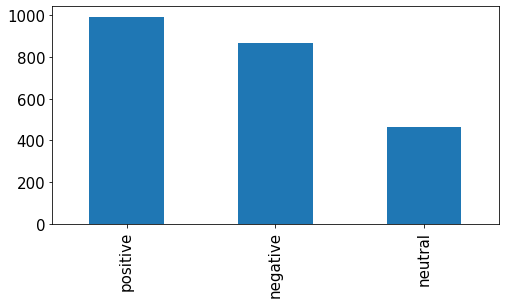

In [16]:
# label distribution
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4

# train
train_df.polarity \
.apply(lambda x: {2:'positive',1:'neutral',0:'negative'}[x])\
.value_counts().plot(kind = 'bar', fontsize = 15)

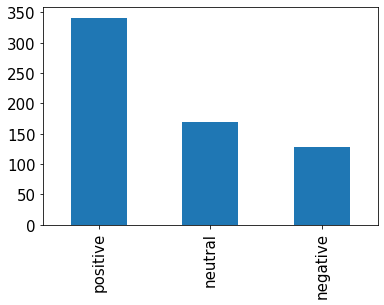

In [15]:
# test
test_df.polarity \
.apply(lambda x: {2:'positive',1:'neutral',0:'negative'}[x])\
.value_counts().plot(kind = 'bar', fontsize = 15)

# model input

In [19]:
# model's input for inference
input_colses = {
    'lstm': ['text_raw_indices'],
    'td_lstm': ['text_left_with_aspect_indices', 'text_right_with_aspect_indices'],
    'atae_lstm': ['text_raw_indices', 'aspect_indices'],
    'ian': ['text_raw_indices', 'aspect_indices'],
    'memnet': ['text_raw_without_aspect_indices', 'aspect_indices'],
    'ram': ['text_raw_indices', 'aspect_indices', 'text_left_indices'],
    'cabasc': ['text_raw_indices', 'aspect_indices', 'text_left_with_aspect_indices', 'text_right_with_aspect_indices'],
    'tnet_lf': ['text_raw_indices', 'aspect_indices', 'aspect_in_text'],
    'aoa': ['text_raw_indices', 'aspect_indices'],
    'mgan': ['text_raw_indices', 'aspect_indices', 'text_left_indices'],
    'bert_spc': ['text_bert_indices', 'bert_segments_ids'], # Sentence Pair Classification
    'aen_bert': ['text_raw_bert_indices', 'aspect_bert_indices'],
}
train_df[input_colses['aen_bert']]

text_raw_bert_indices  \
0                          [CLS] i charge it at night and skip taking the cord with me because of the good battery life . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1                          [CLS] i charge it at night and skip taking the cord with me because of the good battery life . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2                                                                                  [CLS] the tech guy then said the service center does not do 1 - to - 1 exchange and i have to direct my concern to the ` ` sales ' ' team , which is the retail shop which i bought my net ##book from . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3                                                                          [CLS] the tech guy then said the service center does not do 1 - to - 1 exchange and i have to direct my concern to the " sales " team , which is the retail shop which i bought my net ##book from . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
4                                                                                  [CLS] the tech guy then said the service center does not do 1 - to - 1 exchange and i have to direct my concern to the ` ` sales ' ' team , which is the retail shop which i bought my net ##book from . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ...   
2323           [CLS] we also use para ##lles so we can run virtual machines of windows xp professional , windows 7 home premium , windows server enterprise 2003 , and windows server 2008 enterprise . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2324           [CLS] we also use para ##lles so we can run virtual machines of windows xp professional , windows 7 home premium , windows server enterprise 2003 , and windows server 2008 enterprise . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2325           [CLS] we also use para ##lles so we can run virtual machines of windows xp profe

# aspect analysis
### 1. num_aspect_words
### 2. aspect words in text

/ldap_home/yunrui.li/.pyenv/versions/3.6.5/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/ldap_home/yunrui.li/.pyenv/versions/3.6.5/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


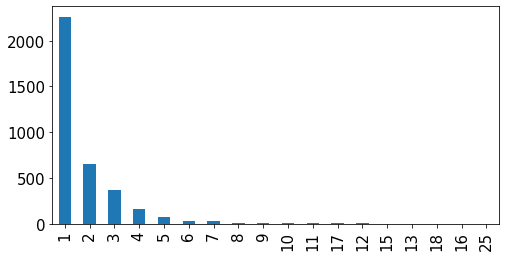

In [213]:
train_df.num_aspect_words = train_df.aspect_in_text.apply(lambda x: x[1]-x[0]+1)
test_df.num_aspect_words = test_df.aspect_in_text.apply(lambda x: x[1]-x[0]+1)

train_df.num_aspect_words.value_counts().plot(kind = 'bar', fontsize = 15)

In [235]:
# aspect words in text
# def aspect_words(row):
#     print (type(row), list(row))
#     aspect_tokens = row.aspect_indices.apply(lambda x: x.split(" "))
#     print (aspect_tokens)
#     aspect_indexs = row.num_aspect_words
#     row.aspect_in_text = aspect_tokens[:aspect_indexs]
aspect_tokens = train_df.aspect_indices.apply(lambda x: x.split(" ")).tolist()
aspect_in_text = [" ".join(t_ls[:n_words]) for t_ls,n_words in zip(aspect_tokens, train_df.num_aspect_words)]
train_df["aspect_in_text_str"] = aspect_in_text
train_df.head()

text_bert_indices  \
0  [CLS] but the staff was so horrible to us . [SEP] staff [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1                                         [CLS] to be completely fair , the only red ##eem ##ing factor was the food , which was above average , but could n ' t make up for all the other def ##iciencies of te ##od ##ora . [SEP] food [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2                    [CLS] the food is uniformly exceptional , with a very capable kitchen which will proudly whip up whatever you feel like eating , whether it ' s on the menu or not . [SEP] food [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3                 [CLS] the food is uniformly exceptional , with a very capable kitchen which will proudly whip up whatever you feel like eating , whether it ' s on the menu or not . [SEP] kitchen [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
4                    [CLS] the food is uniformly exceptional , with a very capable kitchen which will proudly whip up whatever you feel like eating , whether it ' s on the menu or not . [SEP] menu [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         bert_segments_ids  \
0  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [237]:
"staff" in "[CLS] but the staff was so horrible to us . [SEP] staff [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD"

True

In [239]:
train_df["if_aspect_in_text"] = [1 if aspect in text else 0 
 for text, aspect in zip(train_df.text_bert_indices,train_df.aspect_in_text_str)]

In [241]:
train_df.if_aspect_in_text.value_counts()

1    3606
0       2
Name: if_aspect_in_text, dtype: int64

In [242]:
train_df[train_df.if_aspect_in_text == 0]

text_bert_indices  \
2600  [CLS] i must warn the reader that the portions sizes are very small - l ##rb - especially the app ##eti ##zers - rr ##b - , so if you plan to eat until you are full and do not intend to order the chef ' s special tasting menu , prepare to order and pay for an app ##eti ##zer - l ##rb - 1 dish for each person because the portions are not for sharing - rr ##b   
2601  [CLS] i must warn the reader that the portions sizes are very small - l ##rb - especially the app ##eti ##zers - rr ##b - , so if you plan to eat until you are full and do not intend to order the chef ' s special tasting menu , prepare to order and pay for an app ##eti ##zer - l ##rb - 1 dish for each person because the portions are not for sharing - rr ##b   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    bert_segments_ids  \
2600  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2601  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   

                                                                                                                                                                                                                                                                                                                                                        text_raw_bert_indices  \
2600  [CLS] i must warn the reader that the portions sizes are very small - l ##rb - especially the app ##eti ##zers - rr ##b - , so if you plan to eat until you are full and do not intend to order the chef ' s special tasting menu , prepare to order and pay for an app ##eti ##zer - l ##rb - 1 dish for each person because the portions are not for sharing - rr ##b   
2601  [CLS] i must warn the reader that the portions sizes are very small - l ##rb - especially the app ##eti ##zers - rr ##b - , so if you plan to eat until you are full and do not intend to order the chef ' s special tasting menu , prepare to order and pay for an app ##eti ##zer - l ##rb - 1 dish for each person because the portions are not for sharing - rr ##b   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                               aspect_bert_indices  \
2600  [CLS] main en ##tree [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [216]:
train_df["aspect_in_text_str"].nunique()

1202

In [221]:
train_aspect_word = set(train_df["aspect_in_text_str"].unique())

In [218]:
aspect_tokens = test_df.aspect_indices.apply(lambda x: x.split(" ")).tolist()
aspect_in_text = [" ".join(t_ls[:n_words]) for t_ls,n_words in zip(aspect_tokens, test_df.num_aspect_words)]
test_df["aspect_in_text_str"] = aspect_in_text
test_df.head()

text_bert_indices  \
0           [CLS] the bread is top notch as well . [SEP] bread [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1                 [CLS] i have to say they have one of the fastest delivery times in the city . [SEP] delivery times [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2                 [CLS] food is always fresh and hot - ready to eat ! [SEP] food [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3  [CLS] did i mention that the coffee is outstanding ? [SEP] coffee [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
4                                   [CLS] certainly not the best su ##shi in new york , however , it is always fresh , and the place is very clean , sterile . [SEP] place [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             bert_segments_ids  \
0      [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2      [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [219]:
test_df["aspect_in_text_str"].nunique()

520

In [224]:
test_aspect_word = set(test_df["aspect_in_text_str"].unique())

In [226]:
test_aspect_word - train_aspect_word

{'" roy \' s classics "',
 '[ female ] servers',
 'afternoon snack',
 "ama ##zin ' greens salad ##s",
 'an ##cho ##vy dressing',
 'app ##eti ##zer selection',
 'apple tar ##t',
 'argentine cho ##riz ##o app ##eti ##zer',
 'array of su ##shi',
 'art ##ific ##al lobster meat',
 'as ##para ##gus',
 'asian fusion',
 'asian salad',
 'assortment of wraps',
 'av ##oca ##do salad',
 'banana pudding',
 'bar menu',
 'bb ##q rib',
 'beans',
 'beer list',
 'bi - level space',
 'big mac',
 'billed',
 'bis ##tro menu',
 'black cod with mis ##o base',
 'black roasted cod ##fish',
 'black vinegar',
 'blue ##berry pancakes',
 'blue bar area',
 'booth by the windows',
 'boutique selection of wines',
 'br ##un ##ch menu',
 'bra ##ised lamb shan ##k with mas ##hed potatoes',
 'bran ##zin ##i',
 'breakfast',
 'breakfast food',
 'breakfast sandwiches',
 'brisk ##et',
 'buffalo chicken kicker ##s',
 'burr ##ito',
 'ca ##ese ##r salad',
 'ca ##jun shrimp',
 'ca ##via ##r - topped stu ##rgeon',
 'cake',
 "calf

# model's input for inference
### bert_spc:

In [230]:
# model's input for inference
input_colses = {
    'lstm': ['text_raw_indices'],
    'td_lstm': ['text_left_with_aspect_indices', 'text_right_with_aspect_indices'],
    'atae_lstm': ['text_raw_indices', 'aspect_indices'],
    'ian': ['text_raw_indices', 'aspect_indices'],
    'memnet': ['text_raw_without_aspect_indices', 'aspect_indices'],
    'ram': ['text_raw_indices', 'aspect_indices', 'text_left_indices'],
    'cabasc': ['text_raw_indices', 'aspect_indices', 'text_left_with_aspect_indices', 'text_right_with_aspect_indices'],
    'tnet_lf': ['text_raw_indices', 'aspect_indices', 'aspect_in_text'],
    'aoa': ['text_raw_indices', 'aspect_indices'],
    'mgan': ['text_raw_indices', 'aspect_indices', 'text_left_indices'],
    'bert_spc': ['text_bert_indices', 'bert_segments_ids'],
    'aen_bert': ['text_raw_bert_indices', 'aspect_bert_indices'],
}
train_df[input_colses['bert_spc']+["aspect_in_text_str"]]
"""
現有Paper在inference需要決定text中的aspect啊. 去 check infer_example.py晚點
"""

text_bert_indices  \
0     [CLS] but the staff was so horrible to us . [SEP] staff [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
1                                            [CLS] to be completely fair , the only red ##eem ##ing factor was the food , which was above average , but could n ' t make up for all the other def ##iciencies of te ##od ##ora . [SEP] food [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
2                       [CLS] the food is uniformly exceptional , with a very capable kitchen which will proudly whip up whatever you feel like eating , whether it ' s on the menu or not . [SEP] food [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3                    [CLS] the food is uniformly exceptional , with a very capable kitchen which will proudly whip up whatever you feel like eating , whether it ' s on the menu or not . [SEP] kitchen [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
4                       [CLS] the food is uniformly exceptional , with a very capable kitchen which will proudly whip up whatever you feel like eating , whether it ' s on the menu or not . [SEP] menu [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ...   
3603                       [CLS] each table has a pot of boiling water sunken into its surface , and you get platt ##ers of thin sliced meat ##s , various vegetables , and rice and glass noodles . [SEP] pot of boiling water [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3604                       [CLS] each table has a pot of boiling water sunken into its surface , and you get platt ##ers of thin sliced meat ##s , various vegetables , and rice and glass noodles . [SEP] meat ##s [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   
3605               [CLS] each table has a pot of boiling water sunken into its surface , and you get platt ##ers of thin sliced meat ##s , various vegetables , and rice and glass noodles . [SEP] 

In [ ]:
train

In [118]:
# # to understanding each data's physcial meaning
# train_df = []
# columns_name = []
# for i in range(len(trainset)):
#     tmp = []
#     for k, v in trainset.data[i].items():
#         try:
#             to_str = " ".join(tokenizer.tokenizer.convert_ids_to_tokens(v))
#             #print (to_str)
#             tmp.append(to_str)
#         except:
#             if k == 'aspect_in_text':
#                 v = v.numpy()  # 1-D tensor
#                 #print (v.shape)
#             tmp.append(v)
#         if i <= 0:
#             columns_name.append(k)
#     train_df.append(tmp)
# train_df = pd.DataFrame(train_df,columns=columns_name)

In [ ]:
# check pytorch's model format(that's we need to deliver)